In [3]:
# Author: Jibreal Khan
# Title: Algorithm 4
# Description: Energy-Efficient Cooperative Offloading for Edge Computing-Enabled Vehicular Networks


# Notes:
# 1) First thing you need to resolve is how to get gurobipy imported.
# 2) for DD in speedList: This actually refers to the number of RSUs. Helps creating their sets
# 3) energy_mdl = Model("EnergyModel") , seems to be a function in the gurobi library. Perhpahs I should explore it.
# 4) xSquare, xQube and Tsquare, adding them as variables to our model, but what exactly are they, Additional constraints to handle quadratic and division terms
# 5) energy_mdl.optimize(), you are pretty much calculating the value of the objective function after this. Using the optimal values you have got. You calculate the energy.
# 6) You could generate the other plots by merely varying the independent variables and calculating the optimal values and seeing the changes in the objective function value. 

# libraries to import 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import*                           
import gurobipy as gp
import random
rnd = np.random
from random import randint, choice
from tabulate import tabulate

# define the sets 
U = 3 # number of vehicles
K = 20 # number of RSU

# define the parameters
kappa = 10e-11
Cu = 1000   
N0 = -80   # Noise power
tierCase = ['single', 'two']
objSingleTierD = []
objtwoTierD = []
speedList = range(6,20)
for DD in speedList:                   # 
    for tier in tierCase:              # Goes through both single and two tier cases
        if tier == 'single':
            # single tier data
            Fk = [1.1]*K
            Pk = [50]*K
            R1 = [500]*K # distance for RSU
        else:
            # Two tier data
            Fk = []
            Pk = []
            R1 = [] # distance for RSU
            for k in range(K):
                if k%2 == 0:
                    Fk.append(1.2)
                    Pk.append(55)
                    R1.append(600)
                else:
                    Fk.append(1.0)
                    Pk.append(45)
                    R1.append(400)


        velocity = [(65000+5000*0)/3600, (70000+5000*0)/3600, (75000+5000*0)/3600] # velocity of each vehicle in m/s 0000/3600
        Rreq = [300,400,500] # distance in m

        # Arrival and departure times.
        theta = [0.95, 0.95, 0.95]
        TimeArrival ={}
        TimeDep = {} 


        # sets
        Uset =[i for i in range(U)] # set of vehicles
        Kset =[i for i in range(DD)] # set of RSU # K
        O = [i for i in range(U)] # set of tasks by order
        Ginverse = 1
        g = 10e-5
        B = 5
        Du = [300-5*0,300,300+5*0]
        Cu = 1000

        # equations (1) + (2)
        # Calculating the arrival and departure times of the vehicles for each RSU.
        for u in Uset:
            for k in Kset: 
                TimeArrival[(k,u)] = 1/velocity[u]*(Rreq[u]+k*R1[k])
                TimeDep[(k,u)] = 1/velocity[u]*(Rreq[u]+(k+1)*R1[k])

        # Mathematical model
        energy_mdl = Model("EnergyModel") 

        # Pricing and incentive decision variables
        x    = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        tcm  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # tranmission time
        tcp  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # computation starting time
        scp  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0) # computation starting time
        scm  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # transmission start time


        Newtcp  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # to get rid of dividing by variable
        xSquare    = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        xQube      = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        tSquare    = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        Onetcm     = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # tranmission time

        CuCude = Cu*Cu*Cu
        energy_mdl.modelSense = GRB.MINIMIZE

        #energy_mdl.setObjective()
        # Setting the objective function of the model.
        energy_mdl.setObjective(quicksum( xQube[k,u]*kappa*CuCude*Newtcp[k,u]-N0*tSquare[k,u]*2**1.1 for k in Kset for u in Uset))

        # Constraint (4)
        energy_mdl.addConstrs(quicksum(x[k,u] for k in Kset) == 1 for u in Uset)


        # Constraints (20), (21), and (22) # fma: replace the value of scm by the arrival time. 
        #energy_mdl.addConstrs(scm[k,u] >= TimeArrival[(k,u)] for k in Kset for u in Uset)
        energy_mdl.addConstrs(TimeArrival[(k,u)] + tcm[k,u] <= TimeDep[(k,u)] for k in Kset for u in Uset)
        energy_mdl.addConstrs(TimeArrival[(k,u)] + tcm[k,u] <= scm[k,u+1] for k in Kset for u in Uset if u !=len(Uset)-1)

        # Constraints (31), (32), (33), and (34)
        energy_mdl.addConstrs(tcm[k,u] - Du[u]*x[k,u]/(B*math.log2(1+Pk[k]*g*Ginverse/N0))>= 0 for k in Kset for u in Uset)
        energy_mdl.addConstrs(x[k,u]-tcp[k,u]<= 0 for k in Kset for u in Uset)
        energy_mdl.addConstrs(scp[k,u-1]+tcp[k,u-1] <= scp[k,u] for k in Kset for u in Uset if u!=0)
        energy_mdl.addConstrs(scp[k,u]+tcp[k,u] <= TimeArrival[(k,u)] for k in Kset for u in Uset)

        # Additional constraints to handle quadratic and division terms
        energy_mdl.addConstrs(xSquare[k,u] == x[k,u]*x[k,u] for k in Kset for u in Uset)
        energy_mdl.addConstrs(xQube[k,u] == xSquare[k,u]*x[k,u] for k in Kset for u in Uset)
        energy_mdl.addConstrs(Newtcp[k,u]*tSquare[k,u] == 1 for u in Uset for k in Kset)
        energy_mdl.addConstrs(tSquare[k,u] == tcp[k,u]*tcp[k,u] for k in Kset for u in Uset)
        energy_mdl.addConstrs(Onetcm[k,u]*tcm[k,u] == 1 for k in Kset for u in Uset)
        energy_mdl.Params.TimeLimit = 100
        energy_mdl.Params.LogToConsole = 0
        energy_mdl.Params.OutputFlag = 0
        energy_mdl.params.NonConvex = 2
        energy_mdl.optimize()
        objVal = 0
        for k in Kset:
            for u in Uset:
                dummy1 = kappa*(Cu**3)*x[k,u].x*x[k,u].x*x[k,u].x/tcp[k,u].x/tcp[k,u].x
                objVal += dummy1-N0*tcm[k,u].x/g/Ginverse*(2**(Du[u]*x[k,u].x/B*Onetcm[k,u].x)-1)
        print('Objective function value: ',objVal)
        if tier == 'single':
            objSingleTierD.append(objVal)
        else:
            objtwoTierD.append(objVal)

Set parameter Username
Set parameter TimeLimit to value 100
Objective function value:  114565728.15420374
Set parameter TimeLimit to value 100
Objective function value:  115306184.98407607
Set parameter TimeLimit to value 100
Objective function value:  112289489.6124859
Set parameter TimeLimit to value 100
Objective function value:  112495515.3078177
Set parameter TimeLimit to value 100
Objective function value:  110621128.77604023
Set parameter TimeLimit to value 100
Objective function value:  111139096.71791208
Set parameter TimeLimit to value 100
Objective function value:  109345997.32359062
Set parameter TimeLimit to value 100
Objective function value:  109560287.53992249
Set parameter TimeLimit to value 100
Objective function value:  108339808.56403013
Set parameter TimeLimit to value 100
Objective function value:  108737227.3961499
Set parameter TimeLimit to value 100
Objective function value:  107525636.13664147
Set parameter TimeLimit to value 100
Objective function value:  107

In [280]:
# Baseline Scheme for comparison (Best Effort First)

# libraries to import 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import*
import gurobipy as gp
import random
rnd = np.random
from random import randint, choice
from tabulate import tabulate

# define the sets 
U = 3 # number of vehicles
K = 20 # number of RSU

# define the parameters
kappa = 10e-11
Cu = 1000
N0 = -80
tierCase = ['single', 'two']
objSingleTierDBEF = []
objtwoTierDBEF = []
speedList = range(10,16)
for DD in speedList:
    for tier in tierCase:
        if tier == 'single':
            # single tier data
            Fk = [1.1]*K
            Pk = [50]*K
            R1 = [500]*K # distance for RSU
        else:
            Fk = []
            Pk = []
            R1 = [] # distance for RSU
            for k in range(K):
                if k%2 == 0:
                    Fk.append(1.2)
                    Pk.append(55)
                    R1.append(600)
                else:
                    Fk.append(1.0)
                    Pk.append(45)
                    R1.append(400)

        velocity = [(65000+5000*0)/3600, (70000+5000*0)/3600, (75000+5000*0)/3600] # velocity of each vehicle in m/s 0000/3600
        velocity = [(65000+5000*0)/3600]*DD # velocity of each vehicle in m/s 0000/3600
        Rreq = [300,400,500] # distance in m
        Rreq = [350]*DD # distance in m

        theta = [0.95, 0.95, 0.95]
        TimeArrival ={}
        TimeDep = {} 


        # sets
        Uset =[i for i in range(DD)] # set of vehicles
        Kset =[i for i in range(K)] # set of RSU # K
        O = [i for i in range(U)] # set of tasks by order
        Ginverse = 1
        g = 10e-5
        B = 5
        Du = [300-5*0,300,300+5*0]
        Du = [300]*DD
        Cu = 1000

        # equations (1) + (2)
        for u in Uset:
            for k in Kset: 
                TimeArrival[(k,u)] = 1/velocity[u]*(Rreq[u]+k*R1[k])
                TimeDep[(k,u)] = 1/velocity[u]*(Rreq[u]+(k+1)*R1[k])

        # Mathematical model
        energy_mdl = Model("EnergyModel") 

        # Pricing and incentive decision variables
        x    = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        tcm  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # tranmission time
        tcp  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # computation starting time
        scp  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0) # computation starting time
        scm  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # transmission start time


        Newtcp  = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # to get rid of dividing by variable
        xSquare    = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        xQube      = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        tSquare    = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # fraction of task u allocated to RSU k
        Onetcm     = energy_mdl.addVars(Kset,Uset, vtype = GRB.CONTINUOUS) # tranmission time

        CuCude = Cu*Cu*Cu
        energy_mdl.modelSense = GRB.MINIMIZE
        #energy_mdl.setObjective()

        # Setting the objective function
        energy_mdl.setObjective(quicksum( xQube[k,u]*kappa*CuCude*Newtcp[k,u]-N0*tSquare[k,u]*2**1.1 for k in Kset for u in Uset))

        # Adding constraint (4)
        energy_mdl.addConstrs(quicksum(x[k,u] for k in Kset) == 1 for u in Uset)

        # Adding constraint for Best Effort First
        energy_mdl.addConstrs(x[k,u]  == 1/4 for u in Uset for k in Kset if k <4)

        # Constraints (20), (21), and (22) # fma: replace the value of scm by the arrival time. 
        #energy_mdl.addConstrs(scm[k,u] >= TimeArrival[(k,u)] for k in Kset for u in Uset)
        energy_mdl.addConstrs(TimeArrival[(k,u)] + tcm[k,u] <= TimeDep[(k,u)] for k in Kset for u in Uset)
        energy_mdl.addConstrs(TimeArrival[(k,u)] + tcm[k,u] <= scm[k,u+1] for k in Kset for u in Uset if u !=len(Uset)-1)

        # Constraints (31), (32), (33), and (34)
        energy_mdl.addConstrs(tcm[k,u] - Du[u]*x[k,u]/(B*math.log2(1+Pk[k]*g*Ginverse/N0))>= 0 for k in Kset for u in Uset)
        energy_mdl.addConstrs(x[k,u]-tcp[k,u]<= 0 for k in Kset for u in Uset)
        energy_mdl.addConstrs(scp[k,u-1]+tcp[k,u-1] <= scp[k,u] for k in Kset for u in Uset if u!=0)
        energy_mdl.addConstrs(scp[k,u]+tcp[k,u] <= TimeArrival[(k,u)] for k in Kset for u in Uset)

        # Additional constraints to handle quadratic and division terms
        energy_mdl.addConstrs(xSquare[k,u] == x[k,u]*x[k,u] for k in Kset for u in Uset)
        energy_mdl.addConstrs(xQube[k,u] == xSquare[k,u]*x[k,u] for k in Kset for u in Uset)
        energy_mdl.addConstrs(Newtcp[k,u]*tSquare[k,u] == 1 for u in Uset for k in Kset)
        energy_mdl.addConstrs(tSquare[k,u] == tcp[k,u]*tcp[k,u] for k in Kset for u in Uset)
        energy_mdl.addConstrs(Onetcm[k,u]*tcm[k,u] == 1 for k in Kset for u in Uset)
        energy_mdl.Params.TimeLimit = 100
        energy_mdl.Params.LogToConsole = 0
        energy_mdl.Params.OutputFlag = 0
        energy_mdl.params.NonConvex = 2
        energy_mdl.optimize()
        objVal = 0
        for k in Kset:
            for u in Uset:
                dummy1 = kappa*(Cu**3)*x[k,u].x*x[k,u].x*x[k,u].x/tcp[k,u].x/tcp[k,u].x
                objVal += dummy1-N0*tcm[k,u].x/g/Ginverse*(2**(Du[u]*x[k,u].x/B*Onetcm[k,u].x)-1)
        print('Objective function value: ',objVal)
        if tier == 'single':
            objSingleTierDBEF.append(objVal)
        else:
            objtwoTierDBEF.append(objVal)

Set parameter TimeLimit to value 10
Objective function value:  403778821.4878463
Set parameter TimeLimit to value 10
Objective function value:  444156703.63663095
Set parameter TimeLimit to value 10
Objective function value:  484534585.7854156
Set parameter TimeLimit to value 10
Objective function value:  524912467.9342002
Set parameter TimeLimit to value 10
Objective function value:  565290350.0829848
Set parameter TimeLimit to value 10
Objective function value:  605668232.2317694


<Figure size 1080x648 with 0 Axes>

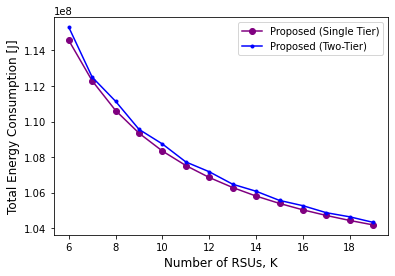

In [287]:
# Plotting the output.

plt.figure(figsize=(15,9))
fig, ax = plt.subplots()
plt.plot(speedList, objSingleTierD,'o-', color='purple', label='Proposed (Single Tier)')
plt.plot(speedList, objtwoTierD,'.-', color = 'blue',label='Proposed (Two-Tier)')
#plt.plot(speedList, objSingleTierDBEF[:4],'o-', color='orange', label='BEF (Single Tier)')
#plt.plot(speedList, objtwoTierDBEFPlot,'.-', color = 'red',label='BEF (Two-Tier)')


plt.legend()
ax.set_xlabel('Number of RSUs, K', fontsize = 12)
ax.set_ylabel('Total Energy Consumption [J]', fontsize = 12)
  
plt.show()